In [55]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm, invgamma, norm
import pickle
import time
import math

In [3]:
%load_ext autoreload
%autoreload 2
from elec_forecast.bootstrap_filter_model import BootstrapFilterModel
from elec_forecast.rm_estimation import RmEstimation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load temperatures data

In [2]:
df_temp=pd.read_csv('data/temp_2016.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')

In [3]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
T_h=list(temp_day.t)

### Load electricity data

In [4]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df.index=range(0,len(df))

In [5]:
df=df.sort_values(by=['Date'])
df.index=range(0,len(df))
#Valeurs intermédiaires à partir de 2017

In [6]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]
df.index=range(0,len(df))

# Gibbs Sampling

## Parameters required

In [7]:
nb_days = 15
temperatures = T_h[:nb_days] #france mean temp in jan 2016
daytypes = list(df[df['Heure']=='15:00']['daytype'][:nb_days])
consumptions = list(df[df['Heure']=='15:00']['Consommation (MW)'][:nb_days])
nb_particles = 10**5

sigma2 = invgamma.rvs(a=10**(-2), scale=10**(2), size = 1)[0]

N_daytype = 9
k_day = np.random.dirichlet(np.ones(N_daytype),1)
kappa = k_day[0].tolist()

u_heat = np.random.normal(14,1)  #fixed parameter, invariant to time

In [10]:
#Data from last year's group
u_heat = 13
kappa = np.array([1/9]*9)
sigma2 = 27000000
sigma2_s_param = 79000000
sigma2_g_param = 127000000
nb_particles = 10000
#len_filtering = 1000

In [11]:
#Execute Gibbs sampling
BFM = BootstrapFilterModel(temperatures,daytypes,consumptions,nb_days,nb_particles,sigma2,kappa,u_heat)

In [12]:
start_time = time.time()
BFM.bf_initialization_gibbs()
print("--- %s seconds ---" % (time.time() - start_time))

self.s[i,0]
74502670.1403
self.g_heat[i,0]
-6.54778009644e+18
self.s[i,0]
635398093.43
self.g_heat[i,0]
-1.93433792736e+18
self.s[i,0]
1117912971.93
self.g_heat[i,0]
-5.01748056368e+16
self.s[i,0]
1239834297.18
self.g_heat[i,0]
-3.34019822892e+17
self.s[i,0]
1333197861.68
self.g_heat[i,0]
-3.34772907639e+18
self.s[i,0]
709429874.071
self.g_heat[i,0]
-1.17003973943e+19
self.s[i,0]
200009405.623
self.g_heat[i,0]
-3.30940031424e+18
self.s[i,0]
1686897845.82
self.g_heat[i,0]
-1.64466764837e+19
self.s[i,0]
930534216.813
self.g_heat[i,0]
-1.80348106296e+19
self.s[i,0]
627538140.031
self.g_heat[i,0]
-2.77113993002e+19
self.s[i,0]
335116418.124
self.g_heat[i,0]
-2.96677956321e+19
self.s[i,0]
1211173741.09
self.g_heat[i,0]
-3.94429399342e+19
self.s[i,0]
937887458.492
self.g_heat[i,0]
-2.91949384265e+19
self.s[i,0]
1996675398.25
self.g_heat[i,0]
-2.80624718549e+19
Gibbs sampling for particle 1/10000
Gibbs sampling for particle 1000/10000
Gibbs sampling for particle 2000/10000
Gibbs sampling for 

In [26]:
variables = BFM.__dict__.keys()
variables

dict_keys(['temperatures', 'daytypes', 'consumptions', 'nb_days', 'nb_particles', 'sigma2', 'kappa', 'u_heat', 's', 'g_heat', 'sigma_s_star_2', 'sigma_g_star_2', 'x_season', 'x_heat', 'x', 'w'])

In [13]:
BFM.x

array([  1.14035681e+20,   8.04457562e+04,   6.92222864e+04, ...,
         6.26610378e+04,   7.41901102e+04,   6.41197377e+04])

In [61]:
sum(BFM.w)

15.114924235721189

In [64]:
#Write initial parameters from Gibbs sampling in a file
timestr = time.strftime("%Y%m%d-%H%M%S")

output_file ='data/parameters_init_' + timestr + '.pkl'
parameters = {
    's_init':BFM.s[nb_days-1,],
    'g_heat_init':BFM.g_heat[nb_days-1,:],
    'sigma_s_init':np.sqrt(BFM.sigma_s_star_2[0,nb_particles-1]),
    'sigma_g_init':np.sqrt(BFM.sigma_g_star_2[0,nb_particles-1]),
    'x_init':BFM.x,
    'w_init':BFM.w,
    'sigma2': sigma2,
    'u_h':u_heat,
    'kappa': kappa
}
output = open(output_file, 'wb')
pickle.dump(parameters, output)
output.close()

# Robbins Monroe parameters estimation

In [4]:
#Steps to Load pickle file
input_file ='data/parameters_init_20180110-024129.pkl'
pkl_file = open(input_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init

{'g_heat_init': array([-1139373.50765916,  -270209.1419129 ,  -449797.54899782, ...,
          -97510.92882799,   -73071.4470343 ,   -88779.62566618]),
 'kappa': array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111]),
 's_init': array([  2.53971204e+08,   1.74479333e+07,   5.59420323e+06, ...,
          1.44451618e-06,   5.79654646e-07,   8.18654197e-07]),
 'sigma2': 27000000,
 'sigma_g_init': 210436.23817816001,
 'sigma_s_init': 6.7179250479583413e-07,
 'u_h': 7.3,
 'w_init': array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.86678274e-38,   2.86678274e-38,   2.86678274e-38]),
 'x_init': array([  2.82190226e+07,   1.93865926e+06,   6.21578137e+05, ...,
          1.60501798e-07,   6.44060718e-08,   9.09615775e-08])}

In [8]:
sigma_init = math.sqrt(np.median(parameters_init["sigma2"]))
sigma_g_init = math.sqrt(np.median(parameters_init["sigma_g_init"]))
sigma_s_init = math.sqrt(np.median(parameters_init["sigma_s_init"]))
u_heat_init = math.sqrt(np.median(parameters_init["u_h"]))

In [78]:
sigma_init = 10**3
sigma_g_init = 10**3
sigma_s_init = 10**3
u_heat_init = 13

In [161]:
variance_epsilon = np.diag(np.array(([10**2,10**2,1,10**2])))

In [167]:
def gamma(n):
    return 1/(10*n)

In [94]:
test = truncnorm.rvs(a=0,b=np.inf,scale=10**3,size=100000)
MIN, MAX = np.min(test), np.max(test)
MIN, MAX

(0.0210384756659057, 4228.713860454699)

In [152]:
def f_sigma_s(sigma_s): 
    sigma_s_min, sigma_s_max = MIN, MAX
    if sigma_s < sigma_s_min :
        f_sigma_s = sigma_s_min
    elif sigma_s > sigma_s_max :
        f_sigma_s = sigma_s_max
    else :
        f_sigma_s = sigma_s
    
    return f_sigma_s

def f_sigma_g(sigma_g):
    sigma_g_min, sigma_g_max = MIN, MAX
    if sigma_g < sigma_g_min :
        f_sigma_g = sigma_g_min
    elif sigma_g > sigma_g_max :
        f_sigma_g = sigma_g_max
    else :
        f_sigma_g = 10*sigma_g
    
    return f_sigma_g 

def f_u_heat(u_heat):
    u_heat_min = 0
    u_heat_max = 30
    if u_heat < u_heat_min :
        f_u_heat = u_heat_min
    elif u_heat > u_heat_max :
        f_u_heat = np.sqrt(u_heat_max)
    else:
        f_u_heat = u_heat
        
    return f_u_heat

def f_sigma(sigma):
    sigma_min, sigma_max = MIN, MAX
    if sigma < sigma_min :
        f_sigma = sigma_min
    elif sigma > sigma_max :
        f_sigma = sigma_max
    else:
        f_sigma = 100*sigma
        
    return f_sigma

def f(sigma_s, sigma_g, u_heat, sigma):
    #sigma_s
    result_sigma_s = f_sigma_s(sigma_s) 
    #sigma_g
    result_sigma_g = f_sigma_g(sigma_g) 
    #u_heat
    result_u_heat = f_u_heat(u_heat)
    #sigma
    result_sigma = f_sigma(sigma) 
    
    return result_sigma_s, result_sigma_g, result_u_heat, result_sigma

In [173]:
iterations = 10000
RME = RmEstimation(sigma_s_init, sigma_g_init, u_heat_init, sigma_init, variance_epsilon, iterations, f, gamma)
RME.estimation()

In [154]:
#RME.cm_u_heat, RME.cm_sigma, RME.cm_sigma_g, RME.cm_sigma

In [155]:
#RME.u_heat[0], RME.sigma, RME.sigma_g, RME.sigma

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

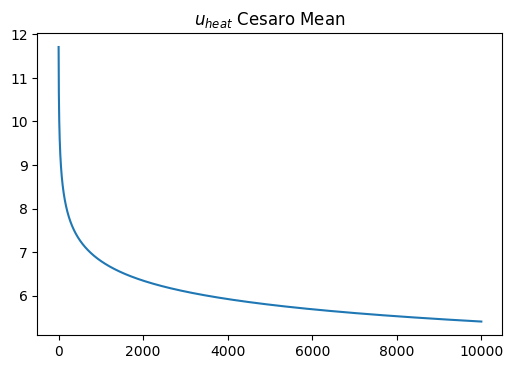

In [174]:
plt.plot(RME.cm_u_heat[0,1:])
plt.title('$u_{heat}$ Cesaro Mean')
plt.show()

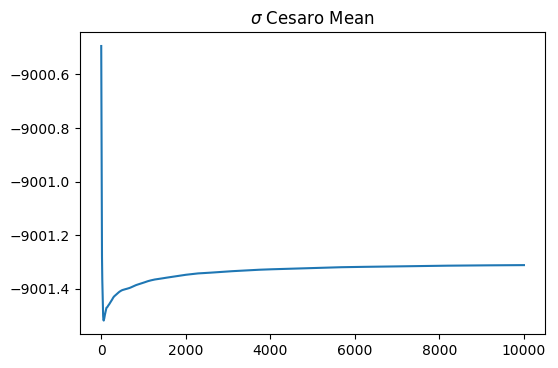

In [175]:
plt.plot(RME.cm_sigma[0,1:])
plt.title('$\sigma$ Cesaro Mean')
plt.show()

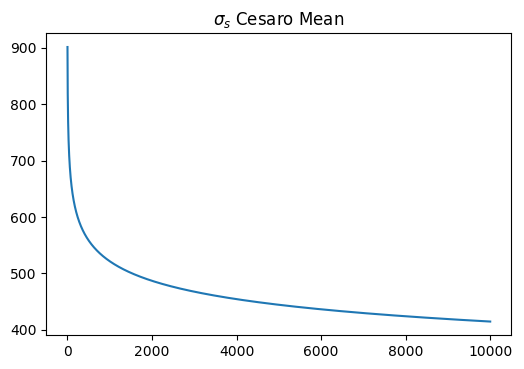

In [176]:
plt.plot(RME.cm_sigma_s[0,1:])
plt.title('$\sigma_s$ Cesaro Mean')
plt.show()

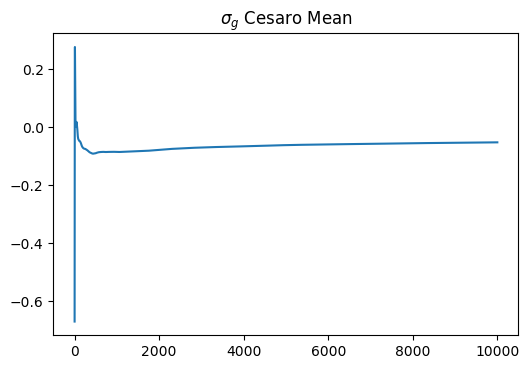

In [177]:
plt.plot(RME.cm_sigma_g[0,1:])
plt.title('$\sigma_g$ Cesaro Mean')
plt.show()